# Import libraries

In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import pathlib
import sys
import random
from typing import List

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from rimworld.utils import read_metadata #, one_hot_encode

In [4]:
# Ik wil deze gewoon importen van utils maar dat mag niet om een of andere reden.


def one_hot_encode(lst: np.ndarray, classes = 11):
    one_hot_encoded = np.zeros((lst.size, classes), dtype=int)
    one_hot_encoded[np.arange(lst.size), lst] = 1
    
    return one_hot_encoded.tolist()

# Get train STFT data and labels (Nsynth JSON data)

In [6]:
data_dir = r"C:\Users\david.isaacspaternos\broncode\data\stft\train" 
train_data_dir = pathlib.Path(data_dir)

# label_dir = r"D:\Projects\nsynth-data\data/nsynth-train"
# train_jsondata = read_metadata(label_dir).sort_index()
# labels = train_jsondata.instrument_family


# Get test STFT data and labels

In [7]:
test_data_dir = r"C:\Users\david.isaacspaternos\broncode\data\stft\valid" 
test_data_dir = pathlib.Path(test_data_dir)

# label_dir = r"D:\Projects\nsynth-data\data/nsynth-test"
# test_jsondata = read_metadata(label_dir).sort_index()
# test_labels = test_jsondata.instrument_family

# View image for inspection

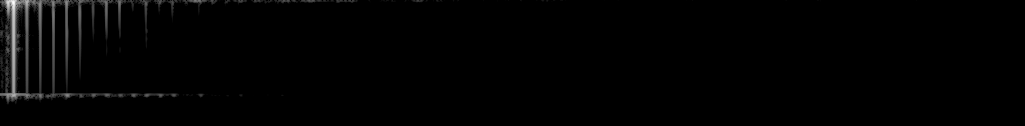

In [8]:
bass_acoustic = list(train_data_dir.glob('bass_acoustic*'))
PIL.Image.open(str(bass_acoustic[100]))


In [ ]:
import imageio

im = imageio.imread(str(bass_acoustic[100]))
print(im[0])

# View JSON-data and labels



In [ ]:
labels

In [5]:
images = list(train_data_dir.glob('*.png'))
image_count = len(images)
print(image_count)
[images[0:5], images[-5:]]

0


[[], []]

# Ensure x and y are the same size

In [ ]:
assert image_count == len(labels.values)

# One hot encode the labels

In [ ]:
labels = one_hot_encode(labels)
test_labels = one_hot_encode(test_labels)

In [45]:
# print(len(images))
# print(len(labels))
# labels[0]

def get_label(path, label="instrument_family"):
    if label=="pitch":
        return int(path.split('-')[2])

    if label=="instrument_family":
        switch = {
            'bass': '00',
            'brass': '01',
            'flute': '02',
            'guitar': '03',
            'keyboard': '04',
            'mallet': '05',
            'organ': '06',
            'reed': '07',
            'string': '08',
            'synth': '09', 
            'vocal': '10',        
        }
        filename = os.path.split(path)[1]
        split = filename.split('_')
        return switch[filename.split('_')[0]]
    
    if label=="instrument":
        switch = {
            'bass_acoustic': '00',
            'bass_electronic': '01',
            'bass_synthetic': '02',
            'brass_acoustic': '03',
            'brass_electronic': '04',
            'brass_synthetic': '05',
            'flute_acoustic': '06',
            'flute_electronic': '07',
            'flute_synthetic': '08',
            'guitar_acoustic': '09',
            'guitar_electronic': '10',
            'guitar_synthetic': '11',
            'keyboard_acoustic': '12',
            'keyboard_electronic': '13',
            'keyboard_synthetic': '14',
            'mallet_acoustic': '15',
            'mallet_electronic': '16',
            'mallet_synthetic': '17',
            'organ_acoustic': '18',
            'organ_electronic': '19',
            'organ_synthetic': '20',
            'reed_acoustic': '21',
            'reed_electronic': '22',
            'reed_synthetic': '23',
            'string_acoustic': '24',
            'string_electronic': '25',
            'string_synthetic': '26',
            'synth_lead_acoustic': '27',
            'synth_lead_electronic': '28',
            'synth_lead_synthetic': '29',
            'vocal_acoustic': '30',
            'vocal_electronic': '31',
            'vocal_synthetic': '32',
            
        } 
        filename = os.path.split(path)[1]
        split = filename.split('_')
        if split[0] == "synth":
            res = split[0] + "_" + split[1] + "_" + split[2]
        else:
            res = split[0] + "_" + split[1]
        return switch[res]

def put_all_files_back_in_1_folder(directory):
    """
        Moves all files from subdirectory to root directory and deletes empty subdirectories
        
        input args:
            directory: a Path (either train, test or valid)
    """
    subfolders = os.listdir(directory)
    #print("all folders", subfolders)
    
    # loop over all label subdirtectories
    for subfolder in subfolders:
        subfolder = os.path.join(directory, subfolder)
        #print("subfolder: ", subfolder )
        files = os.listdir(subfolder)
        
        # move all files to root folder
        for file in files:
            old_filepath = os.path.join(subfolder, file)
            new_file_path = os.path.join(directory, file)
            os.rename(old_filepath, new_file_path)
            
        if len(os.listdir(subfolder)) == 0:
            os.rmdir(subfolder)
    

def add_zero(s):
    if len(s) == 1:
        return '0' + s
    return s
    
def create_subdirectories_for_image_dataset_from_directory(data_dir, nr_of_labels, labeltype="instrument_family", reset=True, create_label_directories=True):
            
    if reset:
        put_all_files_back_in_1_folder(data_dir)
        
    if create_label_directories:
        for i in range(nr_of_labels):
            print("hoi")
            labelclass = add_zero(str(i))
            path = os.path.join(data_dir, labelclass)
            os.mkdir(path)

    
    images = list(data_dir.glob('*.png')) 
    print(images[0])

    for path in images:
        label = get_label(path, labeltype)
        newpath = str(data_dir) + "/" + str(label) + "/" + os.path.basename(path)
        os.rename(path, newpath)
        
#create_subdirectories_for_image_dataset_from_directory(images, 11)
#test_images = list(test_data_dir.glob('*.png')) 
# create_subdirectories_for_image_dataset_from_directory(train_data_dir, 33, labeltype="instrument", reset=False, create_label_directories=True)
# create_subdirectories_for_image_dataset_from_directory(test_data_dir, 33, labeltype="instrument", reset=False, create_label_directories=True)
put_all_files_back_in_1_folder(train_data_dir)
put_all_files_back_in_1_folder(test_data_dir)
        

# Load as train and val dataset with Keras


In [43]:
batch_size = 16
img_height = 126
img_width = 1025

def cut_half_of_image(x, y):
    print(type(x))
    print(x.shape)
    x = tf.slice(x, [0,0,0,0], [0, 126, 512, 1])
    print(" after")
    print(x.shape)
    return x, y

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir, 
    label_mode = 'categorical',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode = 'grayscale',
    shuffle=True
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_data_dir, 
    label_mode = 'categorical',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode = 'grayscale'
)

Found 289205 files belonging to 33 classes.
Found 12678 files belonging to 33 classes.



batch_size = 32
img_height = 126
img_width = 1025

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir, 
    labels = labels,
    image_size=(img_height, img_width),
    batch_size=batch_size)

In [44]:
import keras
from glob import glob
from keras.layers import Input, Dense, Add, BatchNormalization, Conv2D, ReLU, MaxPool2D, Flatten
from keras.models import Model
# path = r'F:\Nsynth\stft\train\*.png'
# path = "../../nsynth-data/data/stft/train/*.png"
# batch_size = 16
# nr_of_labels=11
# gen = geenreet0r(path, batch_size, nr_of_labels)
nr_of_labels=33

model = keras.Sequential([
    keras.layers.Input(shape=(126, 1025, 1)),
    BatchNormalization(),
    keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.1)),
    keras.layers.MaxPooling2D(pool_size=(3, 3)),
    keras.layers.Conv2D(32, kernel_size=(3, 6), activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.1)),
    keras.layers.MaxPooling2D(pool_size=(3, 3)),
    keras.layers.Conv2D(64, kernel_size=(6, 12), activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.1)),
    keras.layers.MaxPooling2D(pool_size=(3, 3)),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.1)),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(nr_of_labels, activation='softmax'),
])

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="checkpoint_resnet18052021",
    save_weights_only=True,
    monitor='val_loss',
    mode='max',
    save_best_only=True)
#opt = keras.optimizers.Adam(learning_rate=0.0001)
#model.compile(loss='categorical_crossentropy', optimizer=opt, metrics='categorical_accuracy')
model = create_res_net()
model.summary()
history = model.fit(x=train_ds, epochs=5, batch_size=batch_size, validation_data=test_ds, verbose=1, callbacks=[model_checkpoint_callback])
model.save("resnet17052021")
# plt.plot(history.history['val_categorical_accuracy'], label='Validation categorical accuracy')
# plt.plot(history.history['categorical_accuracy'], label='Training categorical accuracy')
# plt.legend()
# plt.title('NSynth instrument Detection Performance')
# plt.xlabel('Epochs')
# plt.ylabel('Categorical accuracy')
# plt.savefig('model')

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_26 (InputLayer)           [(None, 126, 1025, 1 0                                            
__________________________________________________________________________________________________
batch_normalization_70 (BatchNo (None, 126, 1025, 1) 4           input_26[0][0]                   
__________________________________________________________________________________________________
conv2d_108 (Conv2D)             (None, 126, 1025, 16 160         batch_normalization_70[0][0]     
__________________________________________________________________________________________________
re_lu_47 (ReLU)                 (None, 126, 1025, 16 0           conv2d_108[0][0]                 
____________________________________________________________________________________________

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['val_categorical_accuracy'], label='Validation categorical accuracy')
plt.plot(history.history['categorical_accuracy'], label='Training categorical accuracy')
plt.legend()
plt.title('NSynth instrument Detection Performance')
plt.xlabel('Epochs')
plt.ylabel('Categorical accuracy')
plt.savefig('model')

# load model and analyse error's


In [ ]:
model = 

In [ ]:
def load_sample(path):
    img = tf.keras.preprocessing.image.load_img(path, color_mode="grayscale")
    img_array = keras.preprocessing.image.img_to_array(img)
    label = get_label(path)
    return img_array, label



def get_label(path, label="instrument_family"):
    if label=="pitch":
        return int(path.split('-')[2])

    if label=="instrument_family":
        switch = {
            'bass': 0,
            'brass': 1,
            'flute': 2,
            'guitar': 3,
            'keyboard': 4,
            'mallet': 5,
            'organ': 6,
            'reed': 7,
            'string': 8,
            'synth': 9, 
            'vocal': 10,        
        }
        filename = os.path.split(path)[1]
        split = filename.split('_')
        return switch[filename.split('_')[0]]
    
    if label=="instrument":
        switch = {
            'bass_acoustic': 0,
            'bass_electronic': 1,
            'bass_synthetic': 2,
            'brass_acoustic': 3,
            'brass_electronic': 4,
            'brass_synthetic': 5,
            'flute_acoustic': 6,
            'flute_electronic': 7,
            'flute_synthetic': 8,
            'guitar_acoustic': 9,
            'guitar_electronic': 10,
            'guitar_synthetic': 11,
            'keyboard_acoustic': 12,
            'keyboard_electronic': 13,
            'keyboard_synthetic': 14,
            'mallet_acoustic': 15,
            'mallet_electronic': 16,
            'mallet_synthetic': 17,
            'organ_acoustic': 18,
            'organ_electronic': 19,
            'organ_synthetic': 20,
            'reed_acoustic': 21,
            'reed_electronic': 22,
            'reed_synthetic': 23,
            'string_acoustic': 24,
            'string_electronic': 25,
            'string_synthetic': 26,
            'synth_lead_acoustic': 27,
            'synth_lead_electronic': 28,
            'synth_lead_synthetic': 29,
            'vocal_acoustic': 30,
            'vocal_electronic': 31,
            'vocal_synthetic': 32,
            
        } 
        filename = os.path.split(path)[1]
        split = filename.split('_')
        if split[0] == "synth":
            res = split[0] + "_" + split[1] + "_" + split[2]
        else:
            res = split[0] + "_" + split[1]
        return switch[res]
    

def reset(batch_size, nr_of_labels=128):
    imgs = np.zeros((batch_size, 126, 1025, 1))
    labels = np.zeros((batch_size, nr_of_labels))
    return imgs, labels

def geenreet0r(path, batch_size, nr_of_labels=128):
    files = glob(path)
    random.shuffle(files)
    imgs, labels = reset(batch_size, nr_of_labels)
    for i, file in enumerate(files):
        in_batch_id = i % batch_size
        if i > 0 and in_batch_id == 0:
            # Send last batch
            yield imgs, labels
            imgs, labels = reset(batch_size, nr_of_labels)
        img, label = load_sample(file)
        imgs[in_batch_id] = img
        labels[in_batch_id, label] = 1  # Dummy coding
    else:
        # Shut down generator
        # TODO: return final batch?
        return None

In [46]:
import keras
from glob import glob
from keras.layers import Input, Dense, Add, BatchNormalization, Conv2D, ReLU, MaxPool2D, Flatten
from keras.models import Model

def relu_bn(inputs):
    relu = ReLU()(inputs)
    bn = BatchNormalization()(relu)
    return bn
def residual_block(x, downsample: bool, filters: int,                                        kernel_size: int = 3):
    y = Conv2D(kernel_size=kernel_size,
               strides= (1 if not downsample else 2),
               filters=filters,
               padding="same")(x)
    y = relu_bn(y)
    y = Conv2D(kernel_size=kernel_size,
               strides=1,
               filters=filters,
               padding="same")(y)
    if downsample:
        x = Conv2D(kernel_size=1,
                   strides=2,
                   filters=filters,
                   padding="same")(x)
    out = Add()([x, y])
    out = relu_bn(out)
    return out
def create_res_net():
    inputs = Input(shape=(126, 1025, 1))
    num_filters = 16
    t = BatchNormalization()(inputs)
    t = Conv2D(kernel_size=3,
               strides=1,
               filters=num_filters,
               padding="same")(t)
    t = relu_bn(t)
    num_blocks_list = [2, 5,2]
    for i in range(len(num_blocks_list)):
        num_blocks = num_blocks_list[i]
        for j in range(num_blocks):
            t = residual_block(t, downsample=(j==0 and i!=0), filters=num_filters)
        num_filters *= 2
    t = MaxPool2D(4)(t)
    t = Flatten()(t)
    outputs = Dense(nr_of_labels, activation='softmax')(t)
    model = Model(inputs, outputs)
    opt = keras.optimizers.Adam(learning_rate=0.00001)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics='categorical_accuracy')
    return model